### Importing Necessary Libraries

In [1]:
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, GlobalAvgPool2D, BatchNormalization
from tensorflow.keras.applications import EfficientNetV2L
from tensorflow.keras.regularizers import l2

from tensorflow.keras.optimizers import Adam

from sklearn.manifold import TSNE

## Data

A detailed discussion and visualization of the data can be seen in [here](Data-Overview.ipynb).

In [2]:
labels = pd.read_csv("./Data/train_labels.csv")
images = ['./Data/train/train/'+str(name)+'.tif' for name in labels['id']]
labels['images'] = images
labels = labels[['id', 'images', 'label']]

In [3]:
class_labels = list(set(labels['label']))
class_names = [
    'letter', 'form', 'email', 'handwritten', 'advertisement', 'scientific report', 'scientific publication',
    'specification', 'file folder', 'news article', 'budget', 'invoice', 'presentation', 'questionnaire', 'resume',
    'memo'
]
label_names = pd.DataFrame({
    'labels': class_labels,
    'names': class_names
})
label_names

,labels,names
0,0,letter
1,1,form
2,2,email
3,3,handwritten
4,4,advertisement
5,5,scientific report
6,6,scientific publication
7,7,specification
8,8,file folder
9,9,news article


In [15]:
fine_tune_data = np.load(f'./Data/EffNet-kP-train-precompute/whole_train_data_precomp_roi_n_4p.npy')
fine_tune_data.shape

(16000, 7680)

## Model Building

## Fine-Tuning Models

We will load our pretrained model in [EfficientNet kPiece Model](EfficientNet-kPiece-Model.ipynb).

In [6]:
def ftmodel():
    inputs = Input(shape=(6*1280))
    x = BatchNormalization()(inputs)
    
    top_dropout_rate = 0.2
    x = Dropout(top_dropout_rate, name='top_dropout_1')(x)
    x = Dense(2048, name='top_dense_1', kernel_initializer="he_normal", kernel_regularizer=l2(1e-4))(x)
    x = Dropout(top_dropout_rate, name='top_dropout_2')(x)
    x = Dense(1024, name='top_dense_2', kernel_initializer="he_normal", kernel_regularizer=l2(1e-4))(x)
    x = Dropout(top_dropout_rate, name='top_dropout_3')(x)
    x = Dense(512, name='top_dense_3', kernel_initializer="he_normal", kernel_regularizer=l2(1e-4))(x)
    x = Dropout(top_dropout_rate, name='top_dropout_final')(x)
    outputs = Dense(16, activation='softmax', name='pred')(x)

    model1 = tf.keras.Model(inputs, outputs, name='EfficientNet-kPiece-FineTune')
    return model1

In [8]:
model1 = ftmodel()
model1.summary()

Model: "EfficientNet-kPiece-FineTune"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 7680)]            0         
                                                                 
 batch_normalization_1 (Batc  (None, 7680)             30720     
 hNormalization)                                                 
                                                                 
 top_dropout_1 (Dropout)     (None, 7680)              0         
                                                                 
 top_dense_1 (Dense)         (None, 2048)              15730688  
                                                                 
 top_dropout_2 (Dropout)     (None, 2048)              0         
                                                                 
 top_dense_2 (Dense)         (None, 1024)              2098176   
                                      

In [9]:
model1.load_weights('./Models/EfficientNet-kP/effnet-kp-model-weights')

### Final Feature Vector Extraction

We will extract the final feature vector for visualization.

In [10]:
model1.compile(loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'], optimizer = Adam(learning_rate = 0.0003))

In [11]:
model1.layers[-3].output.shape

TensorShape([None, 512])

In [12]:
out = model1.layers[-3].output
model2 = tf.keras.Model(model1.input, out, name='EfficientNet-FT-Feature')

In [13]:
model2.summary()

Model: "EfficientNet-FT-Feature"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 7680)]            0         
                                                                 
 batch_normalization_1 (Batc  (None, 7680)             30720     
 hNormalization)                                                 
                                                                 
 top_dropout_1 (Dropout)     (None, 7680)              0         
                                                                 
 top_dense_1 (Dense)         (None, 2048)              15730688  
                                                                 
 top_dropout_2 (Dropout)     (None, 2048)              0         
                                                                 
 top_dense_2 (Dense)         (None, 1024)              2098176   
                                           

In [16]:
train_data = model2.predict(fine_tune_data)

 56/500 [==>...........................] - ETA: 0s

2022-09-27 17:36:19.946261: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-09-27 17:36:19.977930: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


500/500 [==============================] - 1s 2ms/step


In [17]:
train_data.shape

(16000, 512)

## Learnt Representation Visualization

### T-SNE

Looking at the t-SNE embedding for the learnt vector representation for the documents, we get a good idea of which classes are best clustered together by this learnt representation.

In [18]:
tsne = TSNE(n_components=2, learning_rate="auto", random_state=43, init="random")
tsne_embd = tsne.fit_transform(train_data)

In [19]:
labs = labels['label'].to_numpy()
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'orange', 'purple', 'pink', 'brown', 'gray', 'cornflowerblue', 'burlywood', 'magenta', 'indigo']

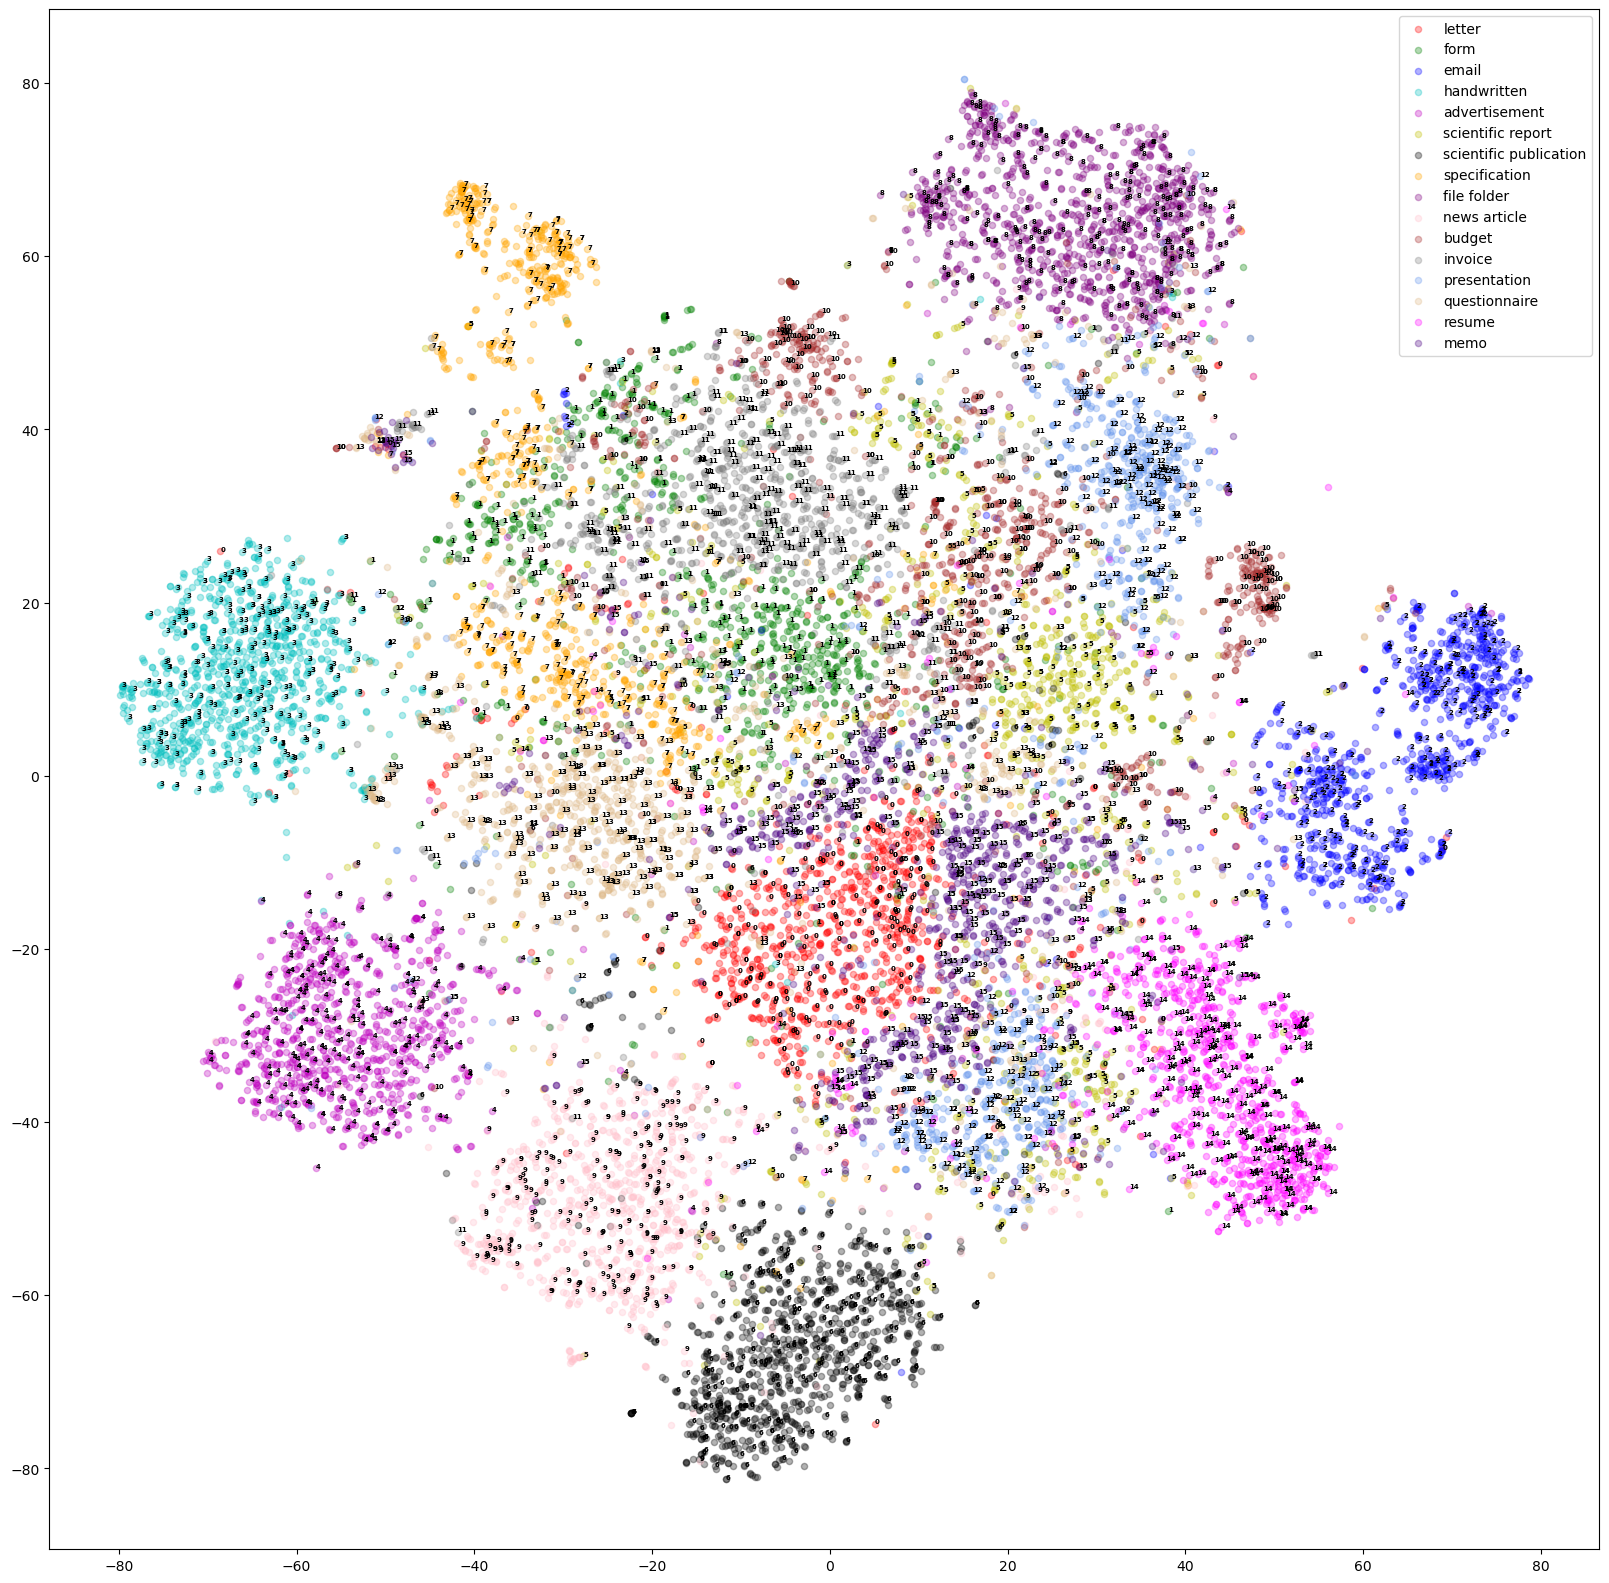

In [20]:
plt.figure(figsize=(20, 20))
for lab, col in zip(class_labels, colors):
    plt.scatter(tsne_embd[labs==lab,0], tsne_embd[labs==lab,1], s=20, c=col, alpha=0.3, label=class_names[lab])
    
    rand = np.random.choice(np.sum(labs==lab), np.sum(labs==lab)//4)
    for pt in rand:
        plt.annotate(lab, (tsne_embd[labs==lab,0][pt], tsne_embd[labs==lab,1][pt]), size=5, weight='bold', color='k')   
plt.legend()
plt.show()